# *SDS_Benchmark*: Compare satellite-derived shoreline to groundtruth


This notebook shows how to compare the satellite-derived shorelines from the different submissions at the 4 different sites:
- Narrabeen, Australia [ref](https://www.nature.com/articles/sdata201624)
- Duck, North Carolina, USA [ref](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2014JC010329)
- Truc Vert, France [ref](https://www.nature.com/articles/s41597-020-00750-5#Tab2)
- Torrey Pines, California, USA [ref](https://www.nature.com/articles/s41597-019-0167-6)

## Initial settings

To run this notebook you will need basic Python packages installed: `numpy`, `scipy`, `pandas`, `matplotlib`, `pytz`.

If you have [CoastSat](https://github.com/kvos/CoastSat) installed, you can activate that envrionment as it has all the necessary packages.

In [9]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json
import pdb
# import utils module located in the repository (utils.py)
import utils

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.getcwd(),'datasets'))
names_datasets = os.listdir(fp_datasets)
names_datasets = [_ for _ in names_datasets if _ not in ['README.md','sites_info.txt']]
print('\nBenchmark datasets available:\n%s'%(names_datasets))
                
# load site info dict if exists or create
fp_info = os.path.join(fp_datasets,'sites_info.txt')
if os.path.exists(fp_info):
    with open(fp_info,'r') as f: sites_info = json.load(f)  
    print('\nLoaded sites_info.txt.')
for key in sites_info.keys(): print('%s: %s'%(key,sites_info[key]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Benchmark datasets available:
['CALAMILLOR', 'DUCK', 'NARRABEEN', 'TORREYPINES', 'TRUCVERT']

Loaded sites_info.txt.
NARRABEEN: {'beach_slope': 0.1, 'contour_level': 0.7, 'epsg': 28356}
DUCK: {'beach_slope': 0.1, 'contour_level': 0.585, 'epsg': 32119}
TRUCVERT: {'beach_slope': 0.05, 'contour_level': 1.5, 'epsg': 32630}
TORREYPINES: {'beach_slope': 0.045, 'contour_level': 0.792, 'epsg': 26946}
CALAMILLOR: {'beach_slope': 0.1, 'contour_level': 0, 'epsg': 2062}


### Plot satellite-derived shoreline time-series against in situ surveys

Select your submission name and this section will plot the time-series against the in situ data. Change the following parameters to your own submission:
- `submission_name`: name of the team (e.g., team_COASTSAT)
- `submission_type`: level of processing of the shoreline time-series (`raw_timeseries` or `tidally_corrected_timeseries`)

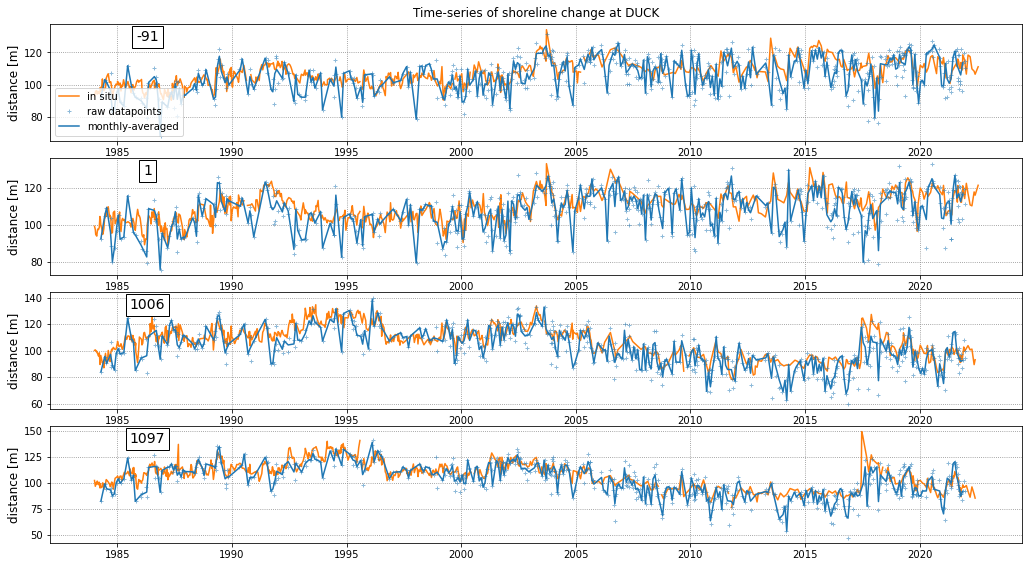

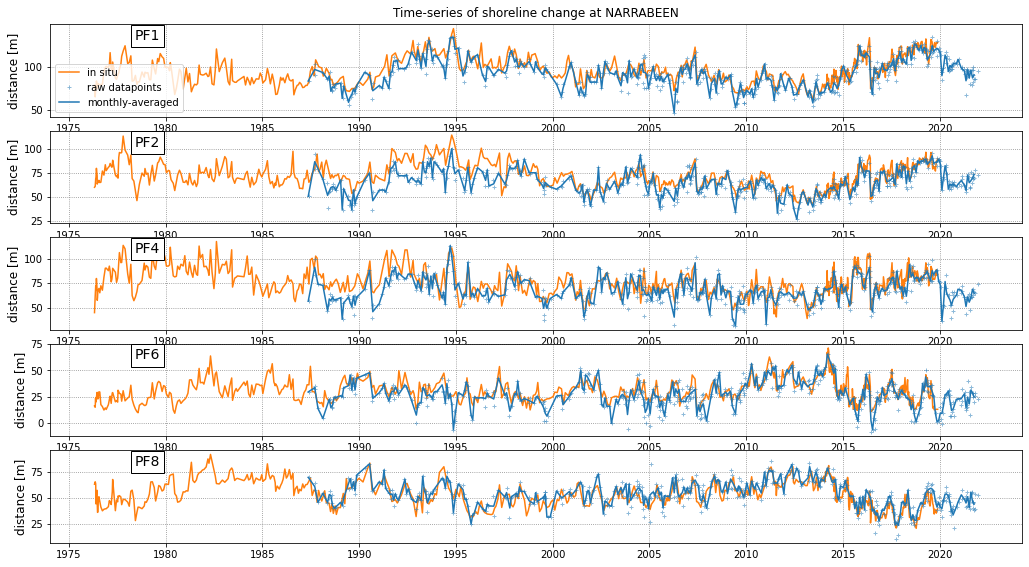

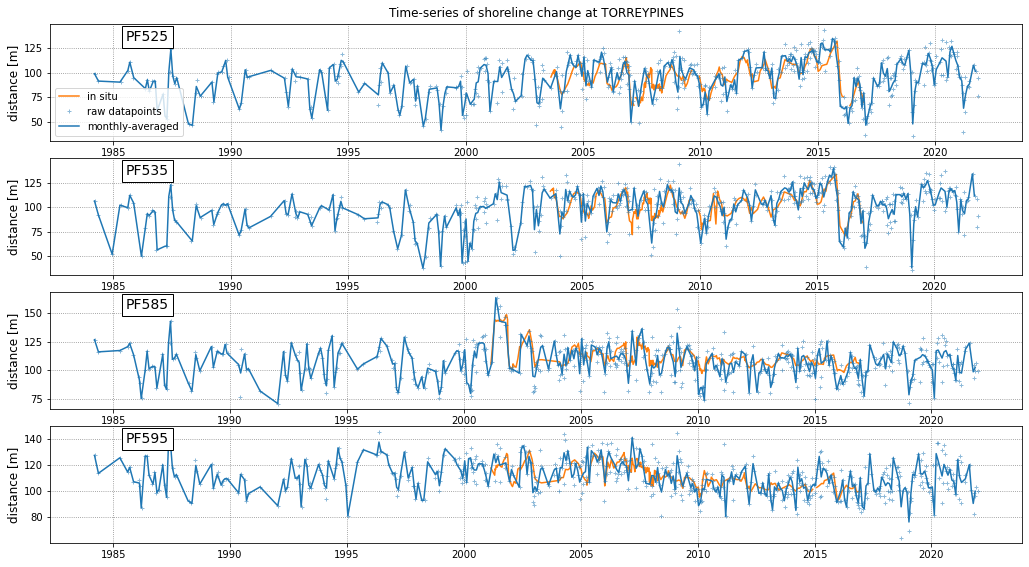

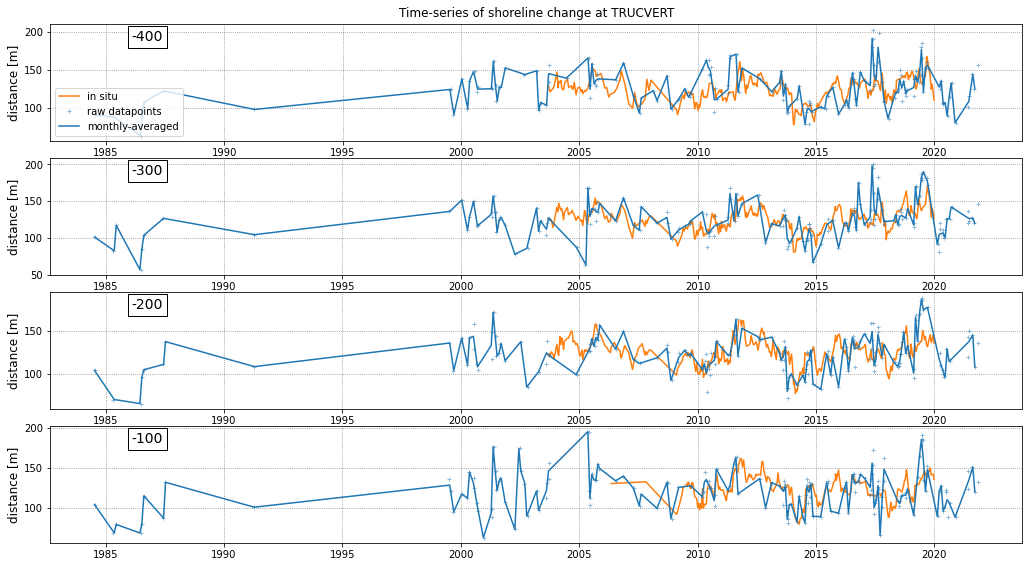

In [13]:
# submission team name
submission_name = 'team_COASTSAT'
# type of submission (MSL, MHWS, or raw_timeseries)
submission_type = 'tidally_corrected_timeseries_MHWS'
groundtruth_type = 'groundtruth_MHWS'
submission_folder = os.path.join(os.getcwd(),'submissions',submission_name)
submission_sites = os.listdir(submission_folder)
# create folder to store comparisons
output_folder = os.path.join(submission_folder,'0_comparison_%s'%submission_type,'ts')
if not os.path.exists(output_folder): os.makedirs(output_folder)
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }
# loop through sites
for sitename in names_datasets:
    if sitename not in submission_sites: continue
    # load satellite time-series
    fp_tc_timeseries = os.path.join(submission_folder,sitename,submission_type)
    fn_transects = os.listdir(fp_tc_timeseries)
    transects = selected_transects[sitename]
    # load groundtruth
    data_folder = os.path.join(fp_datasets,sitename)
    with open(os.path.join(data_folder, '%s_%s.pkl'%(sitename,groundtruth_type)), 'rb') as f:
        gt = pickle.load(f)  
    # make plot comparing the time-series
    fig = plt.figure(figsize=[15,8], tight_layout=True)
    fig.suptitle('Time-series of shoreline change at %s'%(sitename))
    gs = gridspec.GridSpec(len(transects),1)
    gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.15)
    for i,key in enumerate(transects):
        fn = os.path.join(fp_tc_timeseries,'%s_timeseries_tidally_corrected.csv'%key)
        df = pd.read_csv(fn,sep=',',parse_dates=['dates'])  
        chainage = np.array(df[key])
        dates_sat = [_.to_pydatetime() for _ in df['dates']]
        # remove nans
        idx_nan = np.isnan(chainage)
        dates_nonan = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
        chainage = chainage[~idx_nan]
        # compute shoreline monthly averages
        dict_month, dates_month, chainage_month, list_month = utils.monthly_average(dates_nonan, chainage)
        # plot time-series
        ax = fig.add_subplot(gs[i,0])
        ax.plot(gt[key]['dates'], gt[key]['chainages'],'C1-',label='in situ')
        ax.grid(b=True,linestyle=':', color='0.5')
        ax.plot(dates_nonan, chainage,'+', lw=1, color='C0', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
        ax.plot(dates_month, chainage_month, '-', lw=1.5, color='C0', mfc='w', ms=4, label='monthly-averaged')
        ax.set_ylabel('distance [m]', fontsize=12)
        ax.text(0.1,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
                va='top', transform=ax.transAxes, fontsize=14) 
        if i == 0: ax.legend(loc='lower left')
    fig.savefig(os.path.join(output_folder,'%s_comparison.jpg'%sitename),dpi=200)

### Accuracy assessment of the satellite-derived shoreline time-series

This section evaluate the horizontal accuracy of the satellite-derived time-series of shoreline change.
The user can select the transects over which to evaluate the time-series and a few parameters for the assessment:
- `min_days`: 3 days (default), number of days over which it can be assumed that the shoreline has not change. If a survey is located within this time window, it is compared directly to the satellite shorelines.
- `max_days`: 10 days (default), number of days after which a comparison is not realistic any more due to shoreline changes. Between `min_days` and `max_days`, the surveyed shoreline time-series are interpolated to match the date of the satellite shoreline points.

There are also 2 visualisation parameters, the `binwidth` to use when plotting the histogram distributions and the limits (`lims`) over which to plot the errors.  

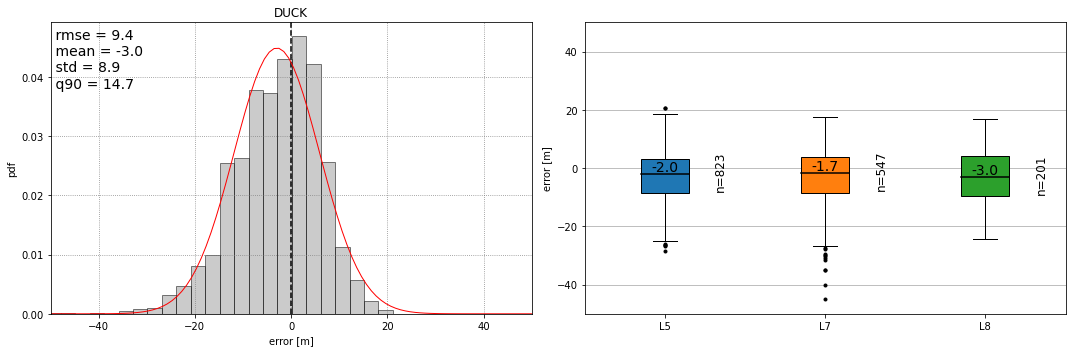

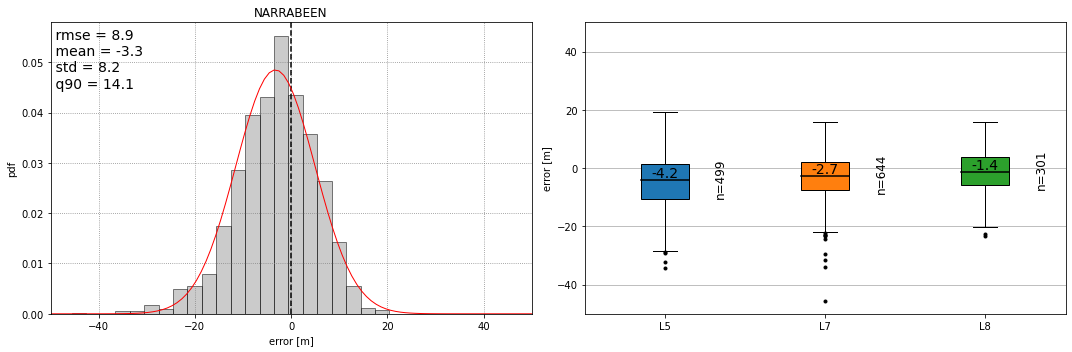

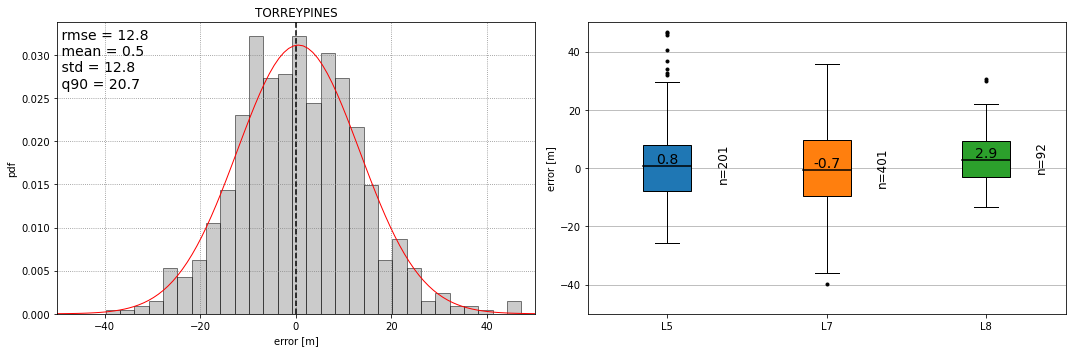

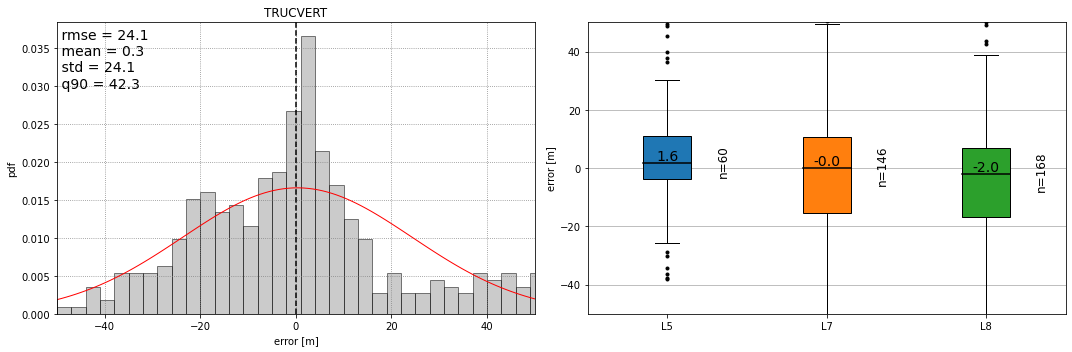

In [14]:
# submission team name
submission_name = 'team_COASTSAT'
# type of submission (tidally-corected_timeseries or raw_timeseries)
submission_type = 'tidally_corrected_timeseries_MHWS'
groundtruth_type = 'groundtruth_MHWS'
submission_folder = os.path.join(os.getcwd(),'submissions',submission_name)
submission_sites = os.listdir(submission_folder)
# create folder to store comparisons
output_folder = os.path.join(submission_folder,'0_comparison_%s'%submission_type)
if not os.path.exists(output_folder): os.makedirs(output_folder)
transect_folder = os.path.join(output_folder,'eval')
if not os.path.exists(transect_folder): os.makedirs(transect_folder)
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }
# parameters for evaluation
settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days':  10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }
# loop through sites
for sitename in names_datasets:
    if sitename not in submission_sites: continue
    # load groundtruth
    data_folder = os.path.join(fp_datasets,sitename)
    with open(os.path.join(data_folder, '%s_%s.pkl'%(sitename,groundtruth_type)), 'rb') as f:
        gt = pickle.load(f) 
    # load satellite time-series
    fp_tc_timeseries = os.path.join(submission_folder,sitename,submission_type)
    fn_transects = os.listdir(fp_tc_timeseries)
    transects = selected_transects[sitename]
    # evaluate the time-series along each transect
    chain_sat_all, chain_sur_all, satnames_all = [], [], []
    for key in transects:
        # load satellite time-series
        fp_ts = os.path.join(fp_tc_timeseries,'%s_timeseries_tidally_corrected.csv'%key)
        ts = pd.read_csv(fp_ts,parse_dates=['dates'])
        ts_sat, ts_sur, satnames, fig = utils.compare_timeseries(ts,gt,key,settings)
        fig.savefig(os.path.join(transect_folder,'%s_transect_%s.jpg'%(sitename,key)), dpi=200)
        plt.close(fig)
        chain_sat_all = np.append(chain_sat_all,ts_sat)
        chain_sur_all = np.append(chain_sur_all,ts_sur)
        satnames_all = satnames_all + satnames 
    # calculate statistics for all transects together
    chain_error = chain_sat_all - chain_sur_all
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all, chain_sat_all)
    R2 = rvalue**2
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
    # histogram
    ax[0].grid(which='major',linestyle=':',color='0.5')
    ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth = settings['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    pval = stats.normaltest(chain_error)[1]
    xlims = settings['lims']
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax[0].plot(x, p, 'r-', linewidth=1)
    ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=settings['lims'], title=sitename)
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90)
    ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes,fontsize=14)
    # boxplot
    data = []
    median_data = []
    n_data = []
    ax[1].yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames_all))):
        idx = np.where([_ == sat for _ in satnames_all])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=14)
        ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax[1].set(ylabel='error [m]', ylim=settings['lims']);
    fig.savefig(os.path.join(output_folder,'%s_accuracy.jpg'%(sitename)), dpi=200)